### Cryosat Level-2 altimetry data visualization.
#### Data search and download: 
#### From: https://eocat.esa.int/sec/#data-services-area/search?osParameters={%22EOCAT-CryoSat.products%22:%22%22,%22commonCriteria%22:%22bbox=-180,-90,180,90%22}
#### Note: the ftp account: Username: <u>anonymous</u>; Password: <u>your email address</u>


In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import netCDF4 as nc
import numpy as np
from utils.geotif_io import readTiff
from utils.imgShow import imgShow
from utils.time_to_dyr import time_to_dyr


In [2]:
## s3 data
path_cryo2_gopm_1b = 'data/cryosat-2/CS_LTA__SIR_GOPM1B_20161030T001715_20161030T001812_C001.nc' # GOPM:LRM-GOP
path_cryo2_gopm_2 = 'data/cryosat-2/CS_LTA__SIR_GOPM_2_20161030T001715_20161030T001812_C001.nc'  
## remote sensing data
path_rsimg = 'data/rs-img/dianchi_s2_20200511_wgs84.tif'
path_rsimg_wat = 'data/water_mask/dianchi_s2_20200511_wat_wgs84.tif'


### Data reading

In [3]:
## 1. s3l2 altimetry data
cryo2_gopm_2 = nc.Dataset(path_cryo2_gopm_2)   ##
cryo2_gopm_1b = nc.Dataset(path_cryo2_gopm_1b)
## 2. remote sensing image
rs_img, rs_img_info = readTiff(path_rsimg)
rs_wat, rs_wat_info = readTiff(path_rsimg_wat)


In [4]:
cryo2_gopm_2.variables.keys()


odict_keys(['agc_01_ku', 'agc_cor_01', 'alt_01', 'alt_20_ku', 'alt_20_plrm_ku', 'atm_cor_sig0_01', 'cog_cor_01', 'dop_cor_01_ku', 'flag_instr_op_mode_01', 'flag_instr_op_mode_20_ku', 'flag_instr_op_mode_20_plrm_ku', 'flag_mcd_20_ku', 'geoid_01', 'gpd_wet_tropo_cor_01', 'gpd_wet_tropo_cor_qual_01', 'hf_fluct_cor_01', 'ind_first_meas_20hz_01', 'ind_first_meas_20hz_01_plrm_ku', 'ind_meas_1hz_20_ku', 'ind_meas_1hz_20_plrm_ku', 'int_path_cor_01', 'internal_cor_sig0_01', 'inv_bar_cor_01', 'iono_cor_gim_01', 'lat_01', 'lat_20_ku', 'lat_20_plrm_ku', 'load_tide_sol1_01', 'load_tide_sol2_01', 'lon_01', 'lon_20_ku', 'lon_20_plrm_ku', 'mean_dyn_topo_sol1_01', 'mean_dyn_topo_sol2_01', 'mean_sea_surf_sol1_01', 'mean_sea_surf_sol2_01', 'mod_dry_tropo_cor_01', 'mod_instr_cor_range_01_ku', 'mod_instr_cor_range_01_plrm_ku', 'mod_instr_cor_sig0_01_ku', 'mod_instr_cor_sig0_01_plrm_ku', 'mod_instr_cor_swh_01_ku', 'mod_instr_cor_swh_01_plrm_ku', 'mod_wet_tropo_cor_01', 'mqe_ocean_20_ku', 'mqe_ocean_20_plrm_

In [6]:
lon_20_ku = cryo2_gopm_2['lon_20_ku'][:]
lat_20_ku = cryo2_gopm_2['lat_20_ku'][:]
time_20_ku = cryo2_gopm_2['time_20_ku'][:]
time_20_ku_dyr = time_to_dyr(time_20_ku) 
print(lon_20_ku.shape, lat_20_ku.shape, time_20_ku_dyr.shape)  ## number of data
print(cryo2_gopm_1b.variables['pwr_waveform_20_ku'][:].shape)  ## waveform
time_20_ku_dyr


(1078,) (1078,) (1078,)
(1078, 128)


array([2016.8279026 , 2016.8279026 , 2016.8279026 , ..., 2016.82790439,
       2016.8279044 , 2016.8279044 ])

#### Calculate the surface water height 

In [38]:
# ## 1. Correction: 1Hz
geo_corr_1hz=['iono_cor_gim_01', 'mod_dry_tropo_cor_01', 'gpd_wet_tropo_cor_01', 'ocean_tide_sol2_01', 'load_tide_sol1_01', 'solid_earth_tide_01', 'pole_tide_01']
corr_1hz, corr_20hz = 0, 0
for cor_1hz_name in geo_corr_1hz:
  corr_1hz += cryo2_gopm_2[cor_1hz_name][:]
## 2. Resample the 1Hz variables to 20Hz variables
times_20 = cryo2_gopm_2['time_20_ku'][:]
times_01 = cryo2_gopm_2['time_01'][:]
times_20_ = np.expand_dims(times_20, axis=1)
dif_time = abs(times_20_ - times_01)
ind_min = dif_time.argmin(axis=1)
corr_01to20 = corr_1hz[ind_min]
## 3. Calculate the corrected surface water height
## 3.1 ocean retracker
h_cor_ocean = cryo2_gopm_2['alt_20_ku'][:] - cryo2_gopm_2['range_ocean_20_ku'][:] - corr_01to20
h_cor_ocean = h_cor_ocean.filled(np.nan)
## 3.2 ocog retracker
h_cor_ocog = cryo2_gopm_2['alt_20_ku'][:] - cryo2_gopm_2['range_ocog_20_ku'][:] - corr_01to20
h_cor_ocog = h_cor_ocog.filled(np.nan)



### Visualization from global perspective

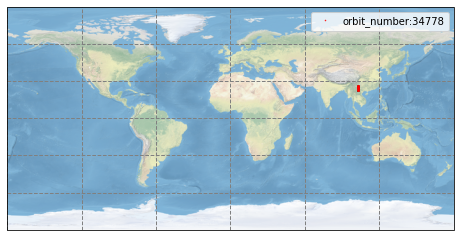

In [39]:
proj = ccrs.PlateCarree(central_longitude=0.0)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection=proj); ax.stock_img()
orbit = 'orbit_number:' + str(cryo2_gopm_2.abs_orbit_number)
ax.plot(cryo2_gopm_2['lon_20_ku'], cryo2_gopm_2['lat_20_ku'], marker='.', markersize=1, 
                                linewidth=0.0, label=orbit, color='red')
ax.gridlines(linewidth=1, color='gray', linestyle='--')
ax.legend()


### Visualization from local perspective

Text(0.5, 1.0, 'merged data')

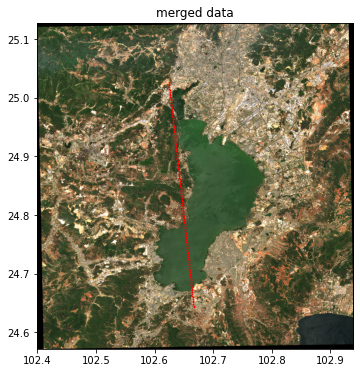

In [40]:
ids = np.where((lat_20_ku[:]>24.64) & (lat_20_ku[:]<25.03))  
fig = plt.figure(figsize=(6, 6))
# plt.subplot(1,3,1)
imgShow(rs_img, extent=rs_img_info['geoextent'])
plt.scatter(x=lon_20_ku[ids], y=lat_20_ku[ids], s=0.5, color='red')  ## altimetry data
plt.title('merged data')


(1850.0, 1858.0)

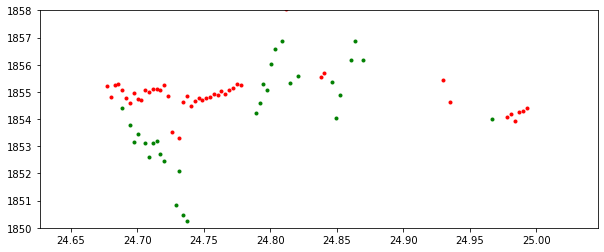

In [20]:
plt.figure(figsize=(10,4))
plt.plot(lat_20_ku[ids], h_cor_ocean[ids], 'g.')
plt.plot(lat_20_ku[ids], h_cor_ocog[ids], 'r.')
plt.ylim(1850, 1858)
